In [1]:
import os
import cv2
import requests
import face_recognition
import time
import numpy as np
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as img
from bs4 import BeautifulSoup as bs
from urllib.parse import unquote_plus
from PIL import Image

In [2]:
def url_to_image(url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype='uint8')
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [3]:
def get_cropped_face(image):
    #image = face_recognition.load_image_file(image_file)
    face_locations = face_recognition.face_locations(image)
    if len(face_locations) == 0: 
        cropped_face = []
        return cropped_face
    a, b, c, d = face_locations[0]
    cropped_face = image[a:c,d:b,:]
    return cropped_face

In [4]:
def get_face_embedding(face):
    return face_recognition.face_encodings(face)

In [5]:
def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)
    embedding_dict = {}
    
    for file in file_list:
        img_path = os.path.join(dir_path, file)
        face = get_cropped_face(img_path)
        embedding = get_face_embedding(face)
        if len(embedding) > 0:  
        # 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
        # os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담깁니다. 
            embedding_dict[os.path.splitext(file)[0]] = embedding[0]
        
    return embedding_dict

In [6]:
def get_face_embedding_dict2(img, name):
    
    embedding_dict = {}
    
    face = get_cropped_face(img)
    
    embedding = get_face_embedding(face)
    if len(embedding) > 0:  
        # 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
        # os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담깁니다. 
        embedding_dict[name] = embedding[0]
        
    return embedding_dict

In [7]:
def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)

In [8]:
def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1

In [9]:
def get_nearest_face(name, top=5):
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    
    for i in range(top+1):
        if i == 0 :   # 첫번째로 나오는 이름은 자기 자신일 것이므로 제외합시다.
            continue
        if sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(i, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))
            img = get_image(Main_Url, sorted_faces[i][0])
            plt.imshow(img)
            plt.show()

In [10]:
def get_nearest_face_r(name, l, top=5):
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    
    for i in range(l-top,l):
        if sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(i, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))
            img = get_image(Main_Url, sorted_faces[i][0])
            plt.imshow(img)
            plt.show()

In [11]:
def get_nearest_face2(name, top=5):
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    
    for i in range(top+1):
        if i == 0 :   # 첫번째로 나오는 이름은 자기 자신일 것이므로 제외합시다.
            print('입력 이미지')
            my_img_path = os.getenv("HOME") + "/aiffel/face_embedding/{}.jpg".format(sorted_faces[i][0])
            img = cv2.imread(my_img_path)
            img = cv2.resize(img, (int(img.shape[1]/2), int(img.shape[0]/2)))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            face = get_cropped_face(img)
            plt.imshow(face)
            plt.show()
            continue
        if sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(i, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))
            my_img_path = os.getenv("HOME") + "/aiffel/face_embedding/{}.jpg".format(sorted_faces[i][0])
            img = cv2.imread(my_img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            face = get_cropped_face(img)
            plt.imshow(face)
            plt.show()

In [12]:
def get_image(Main_Url, name):
    url = Main_Url + unquote_plus(name)
    req = requests.get(url)
    html = req.text
    soup = bs(html, "html.parser")
    img = soup.select('#mw-content-text > div.mw-parser-output > table.infobox.infobox.vcard.vevent > tbody > tr:nth-of-type(2) > td > a > img')
    
    if len(img) > 0:
        res = url_to_image('https:' + img[0].get('src'))
    else:
        res = []
    return res

In [13]:
embedding_dict={}
my_img_path = os.getenv("HOME") + "/aiffel/face_embedding/test2.jpg"
img = cv2.imread(my_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
face = get_cropped_face(img)

embedding = get_face_embedding(face)

if len(embedding) > 0:  
# 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
# os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담깁니다. 
    embedding_dict['test2'] = embedding[0]

In [14]:
for i in range(5):
    my_img_path = os.getenv("HOME") + "/aiffel/face_embedding/img{}.jpg".format(i+1)
    img = cv2.imread(my_img_path)
    #img = cv2.resize(img, (int(img.shape[1]/2), int(img.shape[0]/2)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #cv2.imwrite(my_img_path, img)
    face = get_cropped_face(img)

    embedding = get_face_embedding(face)
    
    if len(embedding) > 0:  
    # 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
    # os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담깁니다. 
        embedding_dict['img{}'.format(i+1)] = embedding[0]

입력 이미지


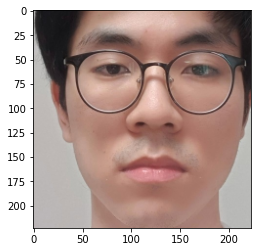

순위 1 : 이름(img5), 거리(0.22309213821238497)


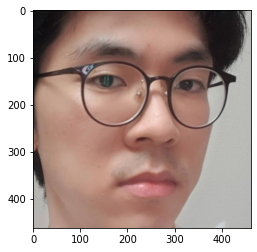

순위 2 : 이름(img2), 거리(0.2526042477993696)


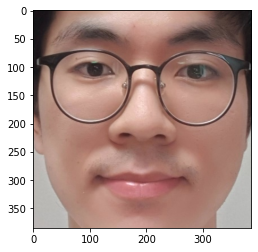

순위 3 : 이름(img3), 거리(0.34532795527785487)


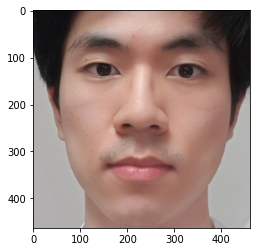

순위 4 : 이름(img4), 거리(0.3590354180310307)


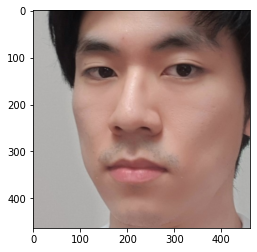

순위 5 : 이름(test2), 거리(0.4042684695895635)


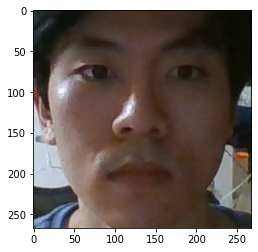

In [15]:
get_nearest_face2('img1')

In [16]:
embedding_dict={}

start = time.time()
while True:
    Main_Url = 'https://ko.wikipedia.org/wiki/'
    name_list = []
    
    list_path = os.getenv("HOME") + "/aiffel/face_embedding/list.txt"
    with open(list_path,'r') as f:
        name_list = f.readlines()
        name_list = list(map(lambda s: s.strip(), name_list))
    name_list = list(map(lambda s: s.strip(), name_list))
    name_set = set(name_list) #set으로 중복제거
    name_list = list(name_set)
    #name_list=['최수종', '차승원', '주지훈', '강동원', '소지섭', '이정재 (배우)', '황정민' ]
#     req = requests.get('https://ko.wikipedia.org/wiki/%EB%B6%84%EB%A5%98:%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD%EC%9D%98_%EB%82%A8%EC%9E%90_%EC%98%81%ED%99%94_%EB%B0%B0%EC%9A%B0')
#     html = req.text
#     soup = bs(html, "html.parser")
#     for i in range(197):
#         i+=1
#         name=soup.select('#mw-pages > div > div > div:nth-of-type(3) > ul > li:nth-of-type({}) > a'.format(i))[0].get('title')
#         name_list.append(name)

    #print(name_list)
    embedding_dict = {}
    for name in name_list:
         
        img = get_image(Main_Url, name)
        #get_face_embedding_dict2(img, name)
        if len(img) == 0:
            continue
        face = get_cropped_face(img)
        if len(face) == 0:
            continue
        embedding = get_face_embedding(face)
        if len(embedding) > 0:  
        # 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
        # os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담깁니다. 
            embedding_dict[name] = embedding[0]
        
    break
print(time.time()-start)
print(len(embedding_dict))

794.6281986236572
386


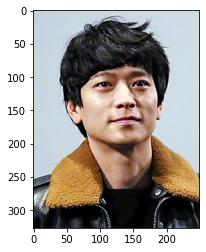

순위 1 : 이름(최제우 (배우)), 거리(0.40219649699525384)


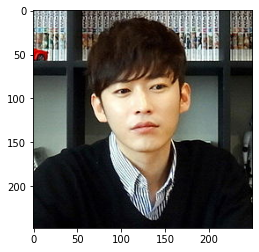

순위 2 : 이름(곽동연), 거리(0.4324315632485465)


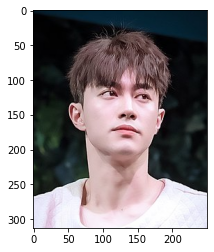

순위 3 : 이름(남주혁), 거리(0.44761209466416413)


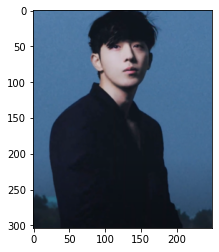

순위 4 : 이름(강지섭), 거리(0.4481847782765981)


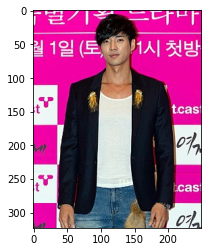

순위 5 : 이름(김민준), 거리(0.44855760337098116)


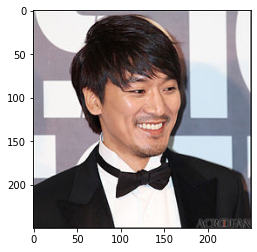

In [17]:
plt.imshow(get_image(Main_Url, '강동원'))
plt.show()
get_nearest_face('강동원')

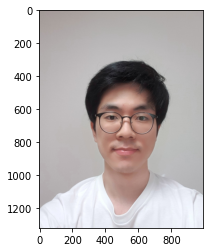

순위 1 : 이름(윤희석), 거리(0.40070879003150567)


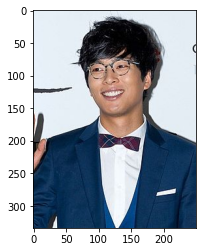

순위 2 : 이름(김기덕 (1960년)), 거리(0.4423256925490069)


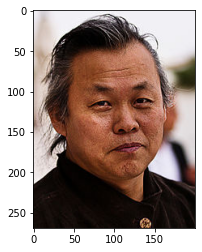

순위 3 : 이름(임원희), 거리(0.45995006863418614)


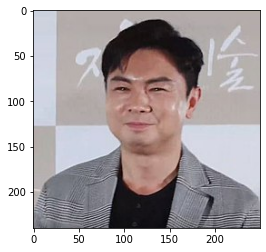

순위 4 : 이름(최수종), 거리(0.4614941754151448)


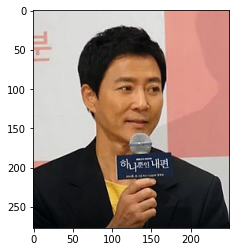

순위 5 : 이름(연정훈), 거리(0.4623078677877396)


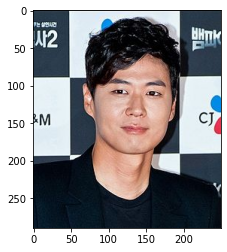

In [18]:
my_img_path = os.getenv("HOME") + "/aiffel/face_embedding/img2.jpg"
img = cv2.imread(my_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
face = get_cropped_face(img)

embedding = get_face_embedding(face)

if len(embedding) > 0:  
# 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
# os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담깁니다. 
    embedding_dict['img2'] = embedding[0]
plt.imshow(img)
plt.show()
get_nearest_face('img2')

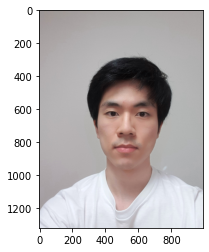

순위 1 : 이름(양익준), 거리(0.4207301540237782)


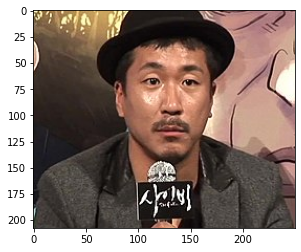

순위 2 : 이름(한주완), 거리(0.4443709314206947)


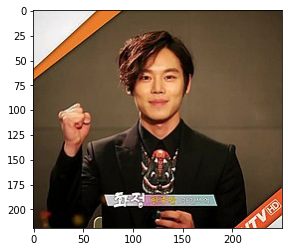

순위 3 : 이름(연정훈), 거리(0.44537040056340127)


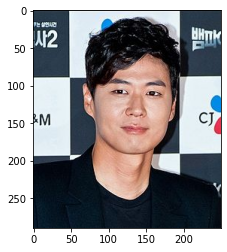

순위 4 : 이름(김태우 (배우)), 거리(0.4503597832323273)


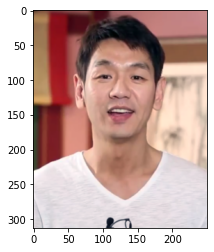

순위 5 : 이름(심진보), 거리(0.45639822485179343)


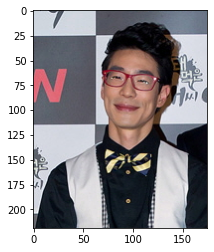

In [19]:
del embedding_dict['img2']
my_img_path = os.getenv("HOME") + "/aiffel/face_embedding/img3.jpg"
img = cv2.imread(my_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
face = get_cropped_face(img)

embedding = get_face_embedding(face)

if len(embedding) > 0:  
# 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
# os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담깁니다. 
    embedding_dict['img3'] = embedding[0]
plt.imshow(img)
plt.show()
get_nearest_face('img3')

순위 382 : 이름(남보원), 거리(0.7569320230554091)


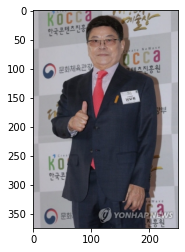

순위 383 : 이름(신성일), 거리(0.7570232190382424)


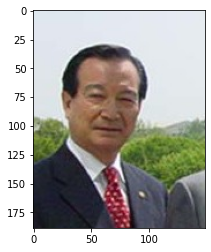

순위 384 : 이름(줄리엔 강), 거리(0.7847291045769931)


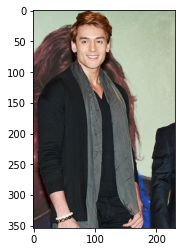

순위 385 : 이름(조재현), 거리(0.8143855578679723)


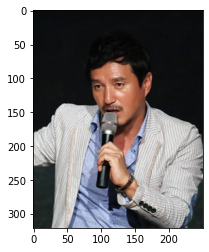

순위 386 : 이름(홍석천), 거리(0.8190592507430094)


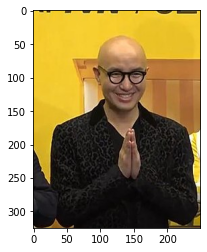

In [20]:
get_nearest_face_r('img3', len(embedding_dict))

In [21]:
while True:
    Main_Url = 'https://ko.wikipedia.org/wiki/'
    name_list = ['한효주', '김태희', '마크 러펄로', '레오나르도 디카프리오', '앤 해서웨이']
    for name in name_list: 
        img = get_image(Main_Url, name)
        if len(img) == 0:
            continue
        face = get_cropped_face(img)
        if len(face) == 0:
            continue
        embedding = get_face_embedding(face)
        if len(embedding) > 0:  
            embedding_dict[name] = embedding[0]
    break

print(len(embedding_dict))

392


이름(한효주), 거리(0.7279876510969073)


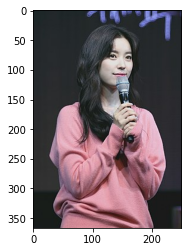

이름(김태희), 거리(0.6776886110874744)


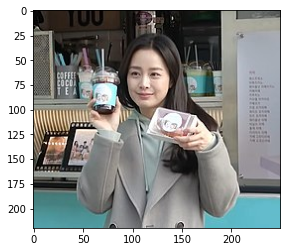

이름(마크 러펄로), 거리(0.9139384367497398)


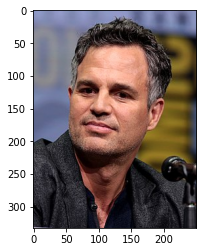

이름(레오나르도 디카프리오), 거리(0.7858376592415435)


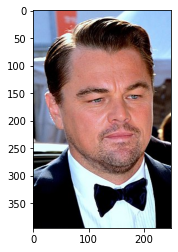

이름(앤 해서웨이), 거리(0.9365242327107108)


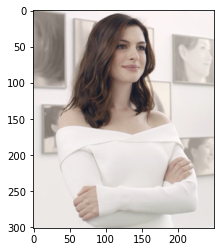

In [22]:
sort_key_func = get_sort_key_func('img3')
sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))

for i in name_list:
    print('이름({}), 거리({})'.format(i, sort_key_func(i)))
    img = get_image(Main_Url, i)
    plt.imshow(img)
    plt.show()          

순위 387 : 이름(레오나르도 디카프리오), 거리(0.7858376592415435)


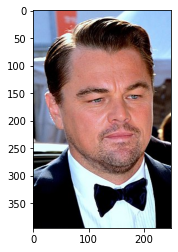

순위 388 : 이름(조재현), 거리(0.8143855578679723)


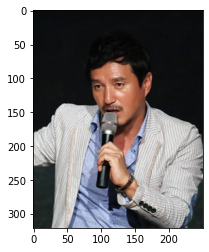

순위 389 : 이름(홍석천), 거리(0.8190592507430094)


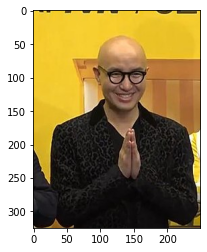

순위 390 : 이름(마크 러펄로), 거리(0.9139384367497398)


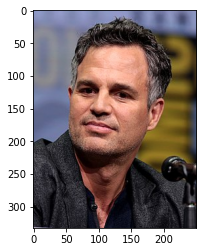

순위 391 : 이름(앤 해서웨이), 거리(0.9365242327107108)


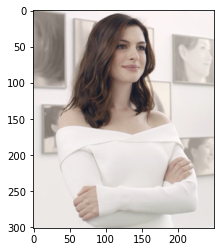

In [23]:
get_nearest_face_r('img3', len(embedding_dict))

직접 촬영한 9장의 사진으로 face embedding을 시도 해 보았는데 어두운 환경에서 안경을 끼고 촬영한 사진과 고개를 옆으로 돌리고 촬영한 사진은 face embedding에 실패하였다. 안경 착용 여부에 따라 임베딩 거리 차이가 크게 나타났다. 표정, 각도와 밝기에 따라서도 차이가 발생하였다. 직접 촬영한 데이터가 적어 일반적으로 단정지을 수는 없지만 6장의 face embedding 결과로 보아 안경이 큰 영향을 미치고 밝기정도에 따라서도 차이가 발생하였다. 각도와 표정 변화 정도에 따라 다르겠지만 내가 촬영한 이미지는 각도와 표정변화가 적다 보니 거리차이가 작게 나타난것 같다.
닮은 연예인을 찾기 위해 위키백과 남자 영화배우, 가수, 희극인 카테고리에 등록되어 있는 인물 중 얼굴을 인식하여 face embedding 가능한 385명의 데이터와 여배우 두명, 외국 남자배우 두명 외국 여자배우 한명을 추가해 사용하였다. 안경 착용 여부에 따라 face embedding이 다르다 보니 닮은 연예인이 다르게 나왔다. BeautifulSoup을 이용한 크롤링을 더 잘 활용한다면 데이터 수집에 많은 도움이 될 것 같다고 느꼈다.

<IPython.core.display.Javascript object>


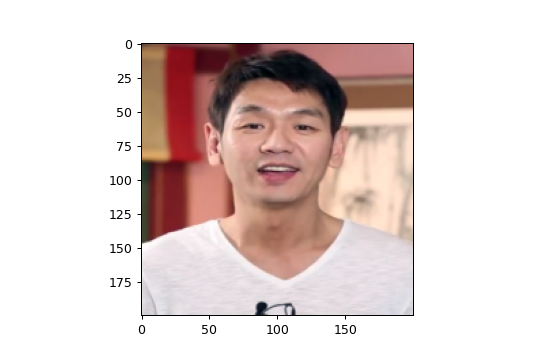

In [27]:
import matplotlib.animation as animation
%matplotlib notebook

fig = plt.figure()
ims = []

sort_key_func = get_sort_key_func('img3')
sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    
for i in range(11):
    if i == 0 :   # 첫번째로 나오는 이름은 자기 자신일 것이므로 제외합시다.
        continue
                
    if sorted_faces[i]:
        img = get_image(Main_Url, sorted_faces[i][0])
        img = cv2.resize(img, (200,200))
        im = plt.imshow(img, animated=True)
        ims.append([im])
    
ani = animation.ArtistAnimation(fig, ims, interval=2000, repeat_delay=1000)

plt.show()

matplotlib animation 이용하여 face embedding거리 가까운 10명 출력